# <a id="top"></a>Intersecting grids with shapes

_Note: This feature requires the shapely module (which is not a dependency of flopy) so must be installed by the user._

This notebook shows the grid intersection functionality in flopy. The intersection methods are available through the GridIntersect object. A flopy model grid is passed to instantiate the object. Then the modelgrid can be intersected with Points, LineStrings and Polygons through the different intersect methods. There are two intersection modes: 
- the first (default mode) is accessed by passing `method='strtree'` to `GridIntersect` and converts the modelgrid to a list of shapes that are sorted into an STR-tree to allow fast spatial queries. This works on structured and vertex grids.
- the second only works on structured grids and is accessed by passing `method='structured'` to `GridIntersect`. These methods use information from the structured grid to limit the search space for intersections and are generally faster.

This notebook showcases the functionality of the GridIntersect class. 


### Table of Contents
- [GridIntersect Class](#gridclass)
- [Rectangular regular grid](#rectgrid)
    - [Polygon with regular grid](#rectgrid.1)
    - [Polyline with regular grid](#rectgrid.2)
    - [MultiPoint with regular grid](#rectgrid.3)
- [Triangular grid](#trigrid)
    - [Polygon with triangular grid](#trigrid.1)
    - [Polyline with triangular grid](#trigrid.2)
    - [MultiPoint with triangular grid](#trigrid.3)
- [Tests](#tests)
- [Timings](#timings)

Import some stuff

In [53]:
import sys
import os
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
    import flopy.discretization as fgrid
    import flopy.plot as fplot
    from flopy.utils.triangle import Triangle as Triangle
    from flopy.utils.gridintersect import GridIntersect
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    import flopy.discretization as fgrid
    import flopy.plot as fplot
    from flopy.utils.triangle import Triangle as Triangle
    from flopy.utils.gridintersect import GridIntersect

import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon
from shapely.strtree import STRtree    

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
numpy version: 1.16.2
matplotlib version: 3.0.3
flopy version: 3.2.13


In [54]:
triangle_exe = None

## <a id="gridclass"></a>[GridIntersect Class](#top)

This GridIntersect class takes a flopy.mfgrid and by default converts it to a list of Shapely geometries and builds a STRTree which can be used to efficiently query the grid to perform intersections. If the method is set to 'structured', the STR-tree is not built and different intersection methods are applied (written by Chris Langevin). The following methods are available:
- ` _rect_grid_to_shape_list`: convert rectangular (structured) modflow grid to list of shapely geometries
- `_sort_strtree_result`: sort STRTree by cellid (to ensure lowest cellid is returned when shapes intersect with multiple grid cells)
- `_usg_grid_to_shape_list`: not yet implemented, convert unstructured grid to list of shapely geometries
- `_vtx_grid_to_shape_list`: convert vertex modflow grid to list of shapely geometries
- `_intersect_point_shapely`: intersect Shapely point with grid
- `_intersect_polygon_shapely`: intersect Shapely Polygon with grid
- `_intersect_linestring_shapely`: intersect Shapely LineString with grid
- `_intersect_point_structured`: intersect Shapely point with grid, using optimized search for structured grids
- `_intersect_polygon_structured`: intersect Shapely Polygon with grid, using optimized search for structured grids
- `_intersect_rectangle_structured`: intersect rectangle with grid to get intersecting node ids
- `_intersect_linestring_structured`: intersect Shapely LineString with structured grid, using optimized search for structured grids
- `_check_adjacent_cells_intersecting_line`: helper function to check adjacent cells in a structured grid for line intersections
- `_get_nodes_intersecting_linestring`: helper function to follow linestring through structured grid
- `intersect_point`: intersect point with grid, method depends on whether 'structured' or 'strtree' is passed at intialization.
- `intersect_linestring`: intersect linestring with grid, method depends on whether 'structured' or 'strtree' is passed at intialization.
- `intersect_polygon`: intersect polygon with grid, method depends on whether 'structured' or 'strtree' is passed at intialization.
- `plot_point`: plot intersect result for point
- `plot_polygon`: plot intersect result for polygons
- `plot_polyline`: plot intersect result for linestrings

## <a id="rectgrid"></a>[Rectangular regular grid](#top)

In [55]:
delc = 10*np.ones(10, dtype=np.float)
delr = 10*np.ones(10, dtype=np.float)

In [56]:
xoff = 0.
yoff = 0.
angrot = 0.
sgr = fgrid.StructuredGrid(delc, delr, top=None, botm=None, xoff=xoff, yoff=yoff, angrot=angrot)

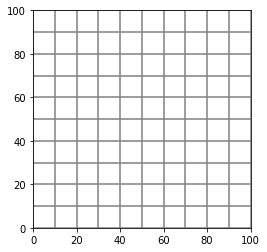

In [57]:
sgr.plot()

### <a id="rectgrid.1"></a>[Polygon with regular grid](#top)
Polygon to intersect with:

In [58]:
p = Polygon(shell=[(15, 15), (20, 50), (35, 80.), (80, 50), (80, 40), (40, 5), (15, 12)], 
            holes=[[(25, 25), (25, 45), (45, 45), (45, 25)]])

Create GridIntersect class

In [59]:
ix = GridIntersect(sgr)

Do the intersect operation for a polygon

In [60]:
result = ix.intersect_polygon(p)

In [61]:
%timeit ix.intersect_polygon(p)

8.05 ms ± 435 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The results are returned as a numpy.recarray containing several fields based on the intersection performed. An explanation of the data in each of the possible fields is given below:
- cellids: contains the cell ids of the intersected grid cells
- vertices: contains the vertices of the intersected shape
- areas: contains the area of the polygon in that grid cell (only for polygons)
- lenghts: contains the length of the linestring in that grid cell (only for linestrings)
- ixshapes: contains the shapely object representing the intersected shape (useful for plotting the result)

Looking at the data for the polygon intersection (convert to pandas.DataFrame for prettier formatting)

In [62]:
# pd.DataFrame(result)
result

rec.array([((2, 3), (((30.0, 70.0), (35.0, 80.0), (40.0, 76.66666666666667), (40.0, 70.0), (30.0, 70.0)),),  66.66666667, <shapely.geometry.polygon.Polygon object at 0x000001846100FC18>),
           ((2, 4), (((40.0, 76.66666666666667), (50.0, 70.0), (40.0, 70.0), (40.0, 76.66666666666667)),),  33.33333333, <shapely.geometry.polygon.Polygon object at 0x0000018461014B70>),
           ((3, 2), (((25.0, 60.0), (30.0, 70.0), (30.0, 60.0), (25.0, 60.0)),),  25.        , <shapely.geometry.polygon.Polygon object at 0x000001846100FF98>),
           ((3, 3), (((30.0, 70.0), (40.0, 70.0), (40.0, 60.0), (30.0, 60.0), (30.0, 70.0)),), 100.        , <shapely.geometry.polygon.Polygon object at 0x000001846100F940>),
           ((3, 4), (((40.0, 70.0), (50.0, 70.0), (50.0, 60.0), (40.0, 60.0), (40.0, 70.0)),), 100.        , <shapely.geometry.polygon.Polygon object at 0x000001846100FE80>),
           ((3, 5), (((50.0, 70.0), (60.0, 63.333333333333336), (60.0, 60.0), (50.0, 60.0), (50.0, 70.0)),),  66.6

Visualizing the results

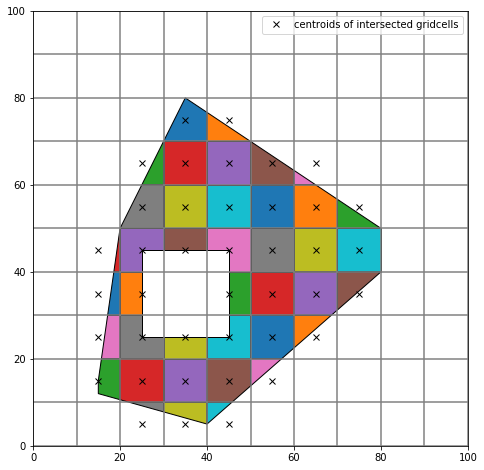

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)
ix.plot_polygon(result, ax=ax)

# only cells that intersect with shape
for irow, icol in result.cellids:
    h2, = ax.plot(sgr.xcellcenters[0, icol], sgr.ycellcenters[irow, 0], "kx", label="centroids of intersected gridcells")
    
ax.legend([h2], [i.get_label() for i in [h2]], loc="best")

Alternatively, the intersection can be calculated using special methods optimized for structured grids. Access these methods by instantiating the GridIntersect class with the `method="structured"` keyword argument.

In [64]:
ixs = GridIntersect(sgr, method="structured")
# pd.DataFrame(ixs.intersect_polygon(p)).head()
ixs.intersect_polygon(p)

rec.array([((2, 3), (((30.0, 70.0), (35.0, 80.0), (40.0, 76.66666666666667), (40.0, 70.0), (30.0, 70.0)),),  66.66666667, <shapely.geometry.polygon.Polygon object at 0x00000184610C2DA0>),
           ((2, 4), (((40.0, 76.66666666666667), (50.0, 70.0), (40.0, 70.0), (40.0, 76.66666666666667)),),  33.33333333, <shapely.geometry.polygon.Polygon object at 0x0000018461109358>),
           ((3, 2), (((25.0, 60.0), (30.0, 70.0), (30.0, 60.0), (25.0, 60.0)),),  25.        , <shapely.geometry.polygon.Polygon object at 0x00000184610C2240>),
           ((3, 3), (((30.0, 70.0), (40.0, 70.0), (40.0, 60.0), (30.0, 60.0), (30.0, 70.0)),), 100.        , <shapely.geometry.polygon.Polygon object at 0x00000184610C2BE0>),
           ((3, 4), (((40.0, 70.0), (50.0, 70.0), (50.0, 60.0), (40.0, 60.0), (40.0, 70.0)),), 100.        , <shapely.geometry.polygon.Polygon object at 0x00000184610C26D8>),
           ((3, 5), (((50.0, 70.0), (60.0, 63.333333333333336), (60.0, 60.0), (50.0, 60.0), (50.0, 70.0)),),  66.6

### <a id="rectgrid.2"></a>[Polyline with regular grid](#top)
MultiLineString to intersect with:

In [65]:
ls1 = LineString([(95, 105), (30, 50)])
ls2 = LineString([(30, 50), (90, 22)])
ls3 = LineString([(90, 22), (0, 0)])
mls = MultiLineString(lines=[ls1, ls2, ls3])

In [66]:
%timeit ix.intersect_linestring(mls)

7.94 ms ± 350 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [67]:
result = ix.intersect_linestring(mls)

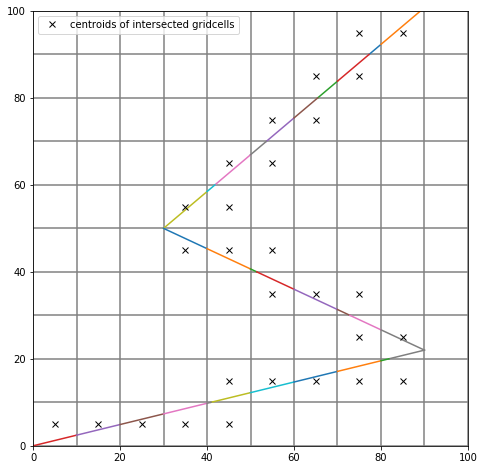

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)
ix.plot_linestring(result, ax=ax)

for irow, icol in result.cellids:
    h2, = ax.plot(sgr.xcellcenters[0, icol], sgr.ycellcenters[irow, 0], "kx", label="centroids of intersected gridcells")
    
ax.legend([h2], [i.get_label() for i in [h2]], loc="best")

Same as before, the intersect for structured grids can also be performed with a different method optimized for structured grids

In [69]:
ixs = GridIntersect(sgr, method="structured")
# pd.DataFrame(ixs.intersect_linestring(mls)).head()
ixs.intersect_linestring(mls)

rec.array([((9, 1), list([[(20.0, 4.888888888888889), (10.0, 2.4444444444444446)]]), 10.29443095, list([<shapely.geometry.linestring.LineString object at 0x00000184611CE358>])),
           ((0, 7), list([[(80.0, 92.3076923076923), (77.27272727272728, 90.0)]]),  3.57259854, list([<shapely.geometry.linestring.LineString object at 0x0000018461201DA0>])),
           ((1, 6), list([[(70.0, 83.84615384615384), (65.45454545454545, 80.0)]]),  5.9543309 , list([<shapely.geometry.linestring.LineString object at 0x0000018461153E10>])),
           ((9, 4), list([[(40.90909090909091, 10.0), (40.0, 9.777777777777779)]]),  0.93585736, list([<shapely.geometry.linestring.LineString object at 0x00000184611CE7B8>])),
           ((2, 5), list([[(60.0, 75.38461538461539), (53.63636363636364, 70.0)]]),  8.33606326, list([<shapely.geometry.linestring.LineString object at 0x0000018461201B00>])),
           ((8, 5), list([[(60.0, 14.666666666666666), (50.0, 12.222222222222221)]]), 10.29443095, list([<shapely.g

### [MultiPoint with regular grid](#top)<a id="rectgrid.3"></a>

MultiPoint to intersect with

In [70]:
mp = MultiPoint(points=[Point(50.0, 0.0), Point(45., 45.), 
                        Point(10., 10.), Point(150., 100.)])

In [71]:
result = ix.intersect_point(mp)

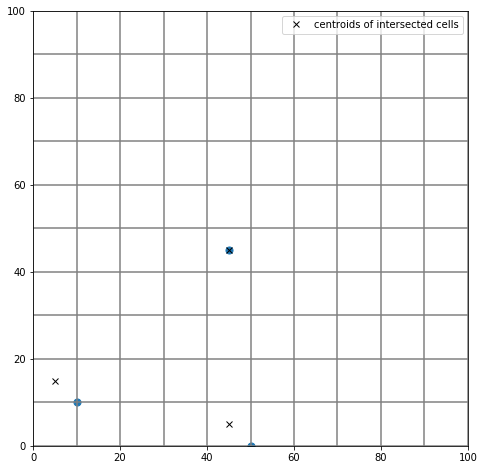

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)
ix.plot_point(result, ax=ax, s=50)
    
for irow, icol in result.cellids:
    h2, = ax.plot(sgr.xcellcenters[0, icol], sgr.ycellcenters[irow, 0], "kx", label="centroids of intersected cells")
    
ax.legend([h2], [i.get_label() for i in [h2]], loc="best")

Same as before, the intersect for structured grids can also be performed with a different method optimized for structured grids

In [73]:
ixs = GridIntersect(sgr, method="structured")
# pd.DataFrame(ixs.intersect_point(mp))
ixs.intersect_point(mp)

rec.array([((9, 4), <shapely.geometry.point.Point object at 0x00000184612605C0>),
           ((5, 4), <shapely.geometry.point.Point object at 0x0000018461260320>),
           ((8, 0), <shapely.geometry.point.Point object at 0x0000018461260630>)],
          dtype=[('cellids', 'O'), ('ixshapes', 'O')])

## <a id="trigrid"></a>[Triangular Grid](#top)

### <a id="trigrid.1"></a>[Polygon with triangular grid](#top)

### <a id="trigrid.2"></a>[LineString with triangular grid](#top)

### <a id="trigrid.3"></a>[MultiPoint with triangular grid](#top)

## <a id="tests"></a>[Tests](#top)
Tests are written for Points, LineStrings and Polygons for both rectangular (regular) grids, triangular grids, and rotated and offset regular grids.

In [74]:
!pytest --cov-report term --cov gridintersect ../../autotest/t065_test_gridintersect.py  

============================= test session starts =============================
platform win32 -- Python 3.7.3, pytest-4.3.1, py-1.8.0, pluggy-0.9.0
rootdir: C:\GitHub\flopy_db, inifile:
plugins: remotedata-0.3.1, openfiles-0.3.2, doctestplus-0.3.0, cov-2.7.1, arraydiff-0.3
collected 0 items / 1 errors


=================================== ERRORS ====================================
____________ ERROR collecting autotest/t065_test_gridintersect.py _____________
ImportError while importing test module 'C:\GitHub\flopy_db\autotest\t065_test_gridintersect.py'.
Hint: make sure your test modules/packages have valid Python names.
Traceback:
..\..\autotest\t065_test_gridintersect.py:12: in <module>
    from flopy.utils.gridintersect import GridIntersect
E   ModuleNotFoundError: No module named 'flopy.utils.gridintersect'
------------------------------- Captured stdout -------------------------------
flopy is installed in C:\Users\dbrak\Anaconda3\lib\site-packages\flopy

----------- coverage: 

Coverage.py warning: Module gridintersect was never imported. (module-not-imported)
Coverage.py warning: No data was collected. (no-data-collected)
C:\Users\dbrak\Anaconda3\lib\site-packages\pytest_cov\plugin.py:229: PytestWarning: Failed to generate report: No data to report.

  self.cov_controller.finish()


## <a id="timings"></a>[Timings](#top)
Comparing performance for the different methods in a large grid. Some helper functions are defined below

In [75]:
def ix_shapely_point(nrnc, npoints=100):
    results = []
    delc = np.ones(nrnc, dtype=np.float)
    delr = np.ones(nrnc, dtype=np.float)
    sgr = fgrid.StructuredGrid(delc, delr, top=None, botm=None)
    ix = GridIntersect(sgr)
    points = np.random.random((npoints, 2)) * nrnc
    for p in [Point(x, y) for x, y in points]:
        results.append(ix.intersect_point(p))
    return np.concatenate(results, axis=0)


def ix_structured_point(nrnc, npoints=100):
    delc = np.ones(nrnc, dtype=np.float)
    delr = np.ones(nrnc, dtype=np.float)
    sgr = fgrid.StructuredGrid(delc, delr, top=None, botm=None)
    ix = GridIntersect(sgr, method="structured")
    points = np.random.random((npoints, 2)) * nrnc
    mp = MultiPoint(points=[Point(x, y) for x, y in points])
    return ix.intersect_point(mp)


def ix_shapely_linestring(nrnc, ls=None):
    if ls is None:
        ls = LineString([(0, 0), (nrnc/3, nrnc)])
    delc = np.ones(nrnc, dtype=np.float)
    delr = np.ones(nrnc, dtype=np.float)
    sgr = fgrid.StructuredGrid(delc, delr, top=None, botm=None)
    ix = GridIntersect(sgr)
    return ix.intersect_linestring(ls)


def ix_structured_linestring(nrnc, ls=None):
    if ls is None:
        ls = LineString([(0, 0), (nrnc/3, nrnc)])
    delc = np.ones(nrnc, dtype=np.float)
    delr = np.ones(nrnc, dtype=np.float)
    sgr = fgrid.StructuredGrid(delc, delr, top=None, botm=None)
    ix = GridIntersect(sgr, method="structured")
    return ix.intersect_linestring(ls)


def ix_shapely_polygon(nrnc, p=Polygon([(10, 10), (540, 430), (730, 80), (250, 0)])):
    delc = np.ones(nrnc, dtype=np.float)
    delr = np.ones(nrnc, dtype=np.float)
    sgr = fgrid.StructuredGrid(delc, delr, top=None, botm=None)
    ix = GridIntersect(sgr)
    return ix.intersect_polygon(p)


def ix_structured_polygon(nrnc, p=Polygon([(10, 10), (540, 430), (730, 80), (250, 0)])):
    delc = np.ones(nrnc, dtype=np.float)
    delr = np.ones(nrnc, dtype=np.float)
    sgr = fgrid.StructuredGrid(delc, delr, top=None, botm=None)
    ix = GridIntersect(sgr, method="structured")
    return ix.intersect_polygon(p)


Below are some results of `%timeit` runs of some intersections on a 1000 x 1000 structured grid. For obvious reasons not having to build the STR-tree saves a significant amount of time for large grids (~ 15 seconds on my laptop).

In [76]:
# nrnc =  1000  # no rows and columns
nrnc = 10  # save time when testing notebook

For point intersections, most of the time required by the shapely approach is needed to build the STR-tree (~15 s). Obviously, the pure numpy approach used in structured mode is unbeatable.

In [77]:
%timeit -n 1 -r 1 ix_shapely_point(nrnc, npoints=100)

16.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [78]:
%timeit ix_structured_point(nrnc, npoints=2)

234 µs ± 15.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


For linestrings, following the linestring through the grid (in structured mode) reduces the amount of intersection calls by a significant amount. This is where the downside of the STR-tree query is obvious. The bounding box of the linestring covers about one third of the grid. The query only reduces the search-space by 2/3 leaving ~333k cells to try to intersect with. On top of the building of the STR-tree the intersection calls take another ~15 seconds.

(Cutting the linestring into pieces would probably improve performance.)

In [79]:
%timeit -n 1 -r 1 ix_shapely_linestring(nrnc)

5.63 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [80]:
%timeit ix_structured_linestring(nrnc)

2.93 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


For Polygons the difference between structured mode and shapely mode is less obvious. Building the STR-tree (~15s) and doing the intersect (~20s) takes a little bit longer than performing the intersection in structured mode. However, note that intersecting with a second similarly sized polygon in shapely mode will only require ~20s, whereas in structured mode the required time will remain ~30 seconds. 

For repeated intersections with Polygons, the shapely method might be preferred over the structured method.

In [81]:
%timeit -n 1 -r 1 ix_shapely_polygon(nrnc)

4.62 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [82]:
%timeit -n 1 -r 1 ix_structured_polygon(nrnc)

3.94 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
